<a href="https://colab.research.google.com/github/punkmic/Topic-Modeling-Reclame-Aqui/blob/master/Topic_Modeling_Reclame_Aqui_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Latent Dirichlet Allocation (LDA) - Reclame Aqui**

LDA is an unsupervised learning algorithm which is able to learns about the structure of the data by analyzing the relationships between words and documents. LDA is based on the idea that each document in a collection can be represented as a mixture of a small number of topics, and that each topic is a distribution over the words in the vocabulary. The model estimates the probability of each word in a document given the topics present in that document, and it also estimates the probability of each topic given the words in the document.

Reference: BLEI, D. M. 2012 Probabilistic topic models. Communications of the ACM, 55(4): pp.77_84.


### **Load data from [Github](https://github.com/punkmic/Topic-Modeling-Reclame-Aqui.git)**

#### **Load dependecies**

In [26]:
%%capture
try:
  import pandas as pd # for data manipulation
  import os # for interacting with the operating system
  from sklearn.cluster import KMeans
  import matplotlib.ticker as ticker
  from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
  from sklearn.metrics import silhouette_score
  import matplotlib.pyplot as plt
  import pickle
  import numpy as np
  import itertools
  from matplotlib.lines import Line2D
  import seaborn as sns
  import csv
  from wordcloud import WordCloud
  import optuna # for hyperparameter optimization
  import pyLDAvis
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_tokenize
  from gensim.models import LdaMulticore
  from gensim.utils import simple_preprocess
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models.phrases import Phrases, Phraser
except:
  !pip install gensim
  !pip install pyldavis
  !pip install optuna
  !pip install wordcloud
  from gensim import models
  from gensim.corpora import Dictionary
  from gensim.models.coherencemodel import CoherenceModel
  from gensim.models import LdaMulticore
  import pyLDAvis.gensim_models as gs
  from gensim.utils import simple_preprocess
  from gensim.models.phrases import Phrases, Phraser
  import optuna # for hyperparameter optimization

#### **Github**

In [ ]:
! ssh-keygen -t rsa -b 4096
# Add github.com to our known hosts
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
# Restrict the key permissions, or else SSH will complain.
! chmod go-rwx /root/.ssh/id_rsa

In [ ]:
! cat /root/.ssh/id_rsa.pub

In [5]:
!git config --global user.email ""
!git config --global user.name ""

In [6]:
!ssh -T git@github.com

Hi punkmic! You've successfully authenticated, but GitHub does not provide shell access.


In [7]:
!git clone git@github.com:punkmic/Topic-Modeling-Reclame-Aqui.git

Cloning into 'Topic-Modeling-Reclame-Aqui'...
remote: Enumerating objects: 16498, done.
remote: Counting objects: 100% (2317/2317), done.
remote: Compressing objects: 100% (1932/1932), done.
remote: Total 16498 (delta 394), reused 2235 (delta 349), pack-reused 14181
Receiving objects: 100% (16498/16498), 153.54 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (1542/1542), done.
Updating files: 100% (14853/14853), done.


In [ ]:
#%cd /content/Topic-Modeling-Reclame-Aqui/

#### **Load dataset**

In [324]:
DATASET_VERSION = 'v1'
WORK_DIR = '/content/Topic-Modeling-Reclame-Aqui'
DATASETS_DIR = '/content/Topic-Modeling-Reclame-Aqui/datasets'

In [325]:
df = pd.read_csv(os.path.join(DATASETS_DIR, f'processed_{DATASET_VERSION}.csv'))

In [506]:
df.head(3)

,title,documents,documents_nouns,bigrams,noun_bigrams,trigrams,noun_trigrams,freq_words_removed,freq_words_removed_nouns
0,pedir cancelado justificativa semana compro,pesquisando bastante novo comprar resolver agu...,semana desconto promoção desconto compra custo...,"[('pesquisando', 'bastante'), ('bastante', 'no...","[('semana', 'desconto'), ('desconto', 'promoçã...","[('pesquisando', 'bastante', 'novo'), ('bastan...","[('semana', 'desconto', 'promoção'), ('descont...",pesquisando bastante novo resolver aguardar se...,semana desconto promoção desconto plataforma c...
1,pedir cancelar,sinceramente decepcionar entrar contato procon...,procon audiência conciliação solicitação produ...,"[('sinceramente', 'decepcionar'), ('decepciona...","[('procon', 'audiência'), ('audiência', 'conci...","[('sinceramente', 'decepcionar', 'entrar'), ('...","[('procon', 'audiência', 'conciliação'), ('aud...",sinceramente decepcionar procon hoje informar ...,procon audiência conciliação solicitação estoq...
2,cobrança indever,cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...,"[('cancelei', 'plano'), ('plano', 'antes'), ('...","[('cancelei', 'período'), ('período', 'platafo...","[('cancelei', 'plano', 'antes'), ('plano', 'an...","[('cancelei', 'período', 'plataforma'), ('perí...",cancelei plano antes terminar período testir g...,cancelei período plataforma fatura gratuito ca...


In [695]:
COLNAME = 'freq_words_removed_nouns'
# remove any na value
df.dropna(subset=[COLNAME], inplace=True)
documents = df[COLNAME]
print(len(documents))
print(documents[:1])

10292
0    semana desconto promoção desconto plataforma c...
Name: freq_words_removed_nouns, dtype: object


In [696]:
LDA_RESULTS_DIR = os.path.join('/content/Topic-Modeling-Reclame-Aqui/lda/', COLNAME)

## **KMeans Model**

#### **K-Means elbow**

The elbow method is a type of method for checking the consistency of clusters created. It  finds the ideal number of clusters in data. Explained variance considers the percentage of variance explained and derives an ideal number of clusters. 

In [697]:
if not os.path.exists(LDA_RESULTS_DIR):
    os.makedirs(LDA_RESULTS_DIR)

In [698]:
# convert text documents to bag of words representation
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(documents)

In [699]:
def plot_elbow(n_clusters= 20):
  elbow_method = {}
  for k in range(1, n_clusters):
    kmeans_elbow = KMeans(n_clusters=k, random_state=22).fit(x)
    elbow_method[k] = kmeans_elbow.inertia_

  # plot elbow
  plt.figure(figsize=[8, 8])
  plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
  plt.title('Elbow', fontsize=16)
  plt.xlabel('Número de grupos')
  plt.ylabel('Soma de quadrados dentro do cluster')

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'elbow_{n_clusters}_{COLNAME}.png'))

  # show the plot
  plt.show()

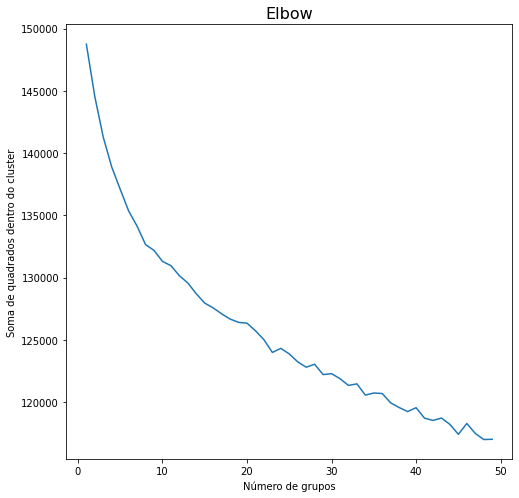

CPU times: user 3min 29s, sys: 746 ms, total: 3min 30s
Wall time: 2min 5s


In [700]:
%%time
plot_elbow(50)

#### **Silhouette**

The silhouette coefficient, or silhouette score, tells how much the object is similar to  other clusters compared to its own cluster. The value varies from –1 to 1, where a high  value indicates that the cluster fits well with itself, and the cluster does not match the neighboring cluster.

In [701]:
clusters = []
scores = []
for n_cluster in range(2, 15):
  kmeans = KMeans(n_clusters=n_cluster, random_state=22).fit(x)
  label = kmeans.labels_
  sil_coeff = silhouette_score(x, label, metric='euclidean')
  print(f"Number of clusters={n_cluster}, Silhouette Coefficient is {sil_coeff}")
  clusters.append(n_cluster) 
  scores.append(sil_coeff)

Number of clusters=2, Silhouette Coefficient is 0.2744384835565165
Number of clusters=3, Silhouette Coefficient is 0.24510692770184656
Number of clusters=4, Silhouette Coefficient is 0.20512252456916316
Number of clusters=5, Silhouette Coefficient is 0.1982183859904667
Number of clusters=6, Silhouette Coefficient is 0.08457610637456682
Number of clusters=7, Silhouette Coefficient is 0.0819936787216198
Number of clusters=8, Silhouette Coefficient is 0.05368931674277288
Number of clusters=9, Silhouette Coefficient is 0.05547213302658763
Number of clusters=10, Silhouette Coefficient is 0.06556935586948522
Number of clusters=11, Silhouette Coefficient is 0.05435967428298022
Number of clusters=12, Silhouette Coefficient is 0.034384644536654345
Number of clusters=13, Silhouette Coefficient is 0.056694888935353356
Number of clusters=14, Silhouette Coefficient is 0.04654483673029013


In [702]:
df_silh = pd.DataFrame({'cluster':clusters,'score': scores})
df_silh.to_csv(os.path.join(LDA_RESULTS_DIR, f'silhouette_scores.csv'), index=False)

#### **Clustering model**

In [703]:
# create a model with two clusters and train it
segments = KMeans(n_clusters=2, random_state=22)
segments.fit(x)

# get model labels
output = segments.labels_.tolist()
output_df = pd.DataFrame({'texts': documents, 'cluster': output})

output_df['cluster'] = segments.labels_.tolist()

cluster_1 = output_df[output_df.cluster == 1]
cluster_0 = output_df[output_df.cluster == 0]

**Wordcloud of cluster 1**

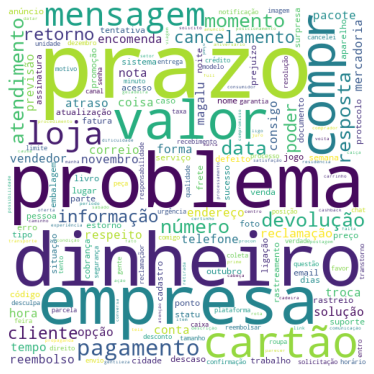

In [704]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False, 
                      colormap='viridis', 
                      background_color ='white', 
                      random_state=20).generate_from_text(' '.join(cluster_1['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_1_wordcloud.png'))
plt.show()

**Wordcloud of cluster 0**

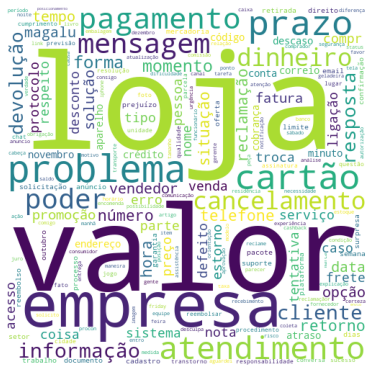

In [705]:
wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(cluster_0['texts']))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.savefig(os.path.join(LDA_RESULTS_DIR, f'cluster_0_wordcloud.png'))
plt.show()

## **LDA models**

#### **Plot coherence**

Coherence score measures how semantically close the words in a topic are to each other. Higher coherence scores indicate that the words in a topic are more semantically similar, and therefore the topic is more interpretable and meaningful.

In [600]:
optimum_topics = []
def plot_coherence(coherence_scores, n_topics, prefix):
  # create the plot
  plt.figure(figsize=[10, 8])

  # create a line plot
  ax = sns.lineplot(x=list(coherence_scores.keys()), y=list(coherence_scores.values()), color='#238C8C')

  # add labels to the axes
  plt.xlabel('Número de Tópicos')
  plt.ylabel('Coerência (score)')
  plt.title("Coerência por número de tópicos", fontsize=16)
  
  # set x-axis limits
  plt.xlim(2, n_topics)

  # customize x-ticks
  plt.xticks(range(2, n_topics, 2))

  # Add a vertical line to show the optimum number of topics
  position = list(coherence_scores.keys())[np.argmax(list(coherence_scores.values()))]
  optimum_topics.append(position)
  plt.axvline(position,  color='#F26457', linestyle='--')  

  # Draw a custom legend
  legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Valor de coerência (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Número de tópicos ótimo')]

  ax.legend(handles=legend_elements, loc='upper right')

  # save plot
  plt.savefig(os.path.join(LDA_RESULTS_DIR, f'{prefix}_coherence_by_topics.png'))

  # show the plot
  plt.show()

In [601]:
NUMBER_OF_TOPICS = 26

#### **Unigram LDA**

In [602]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
tokens = [simple_preprocess(doc, min_len=4) for doc in documents]

# Create a dictionary from the tokens
dictionary = Dictionary(tokens)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.80)

# Create a corpus from the tokens
corpus = [dictionary.doc2bow(token) for token in tokens]

# Create a dict to store the coherence scores
coherence_scores = {}

# Create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

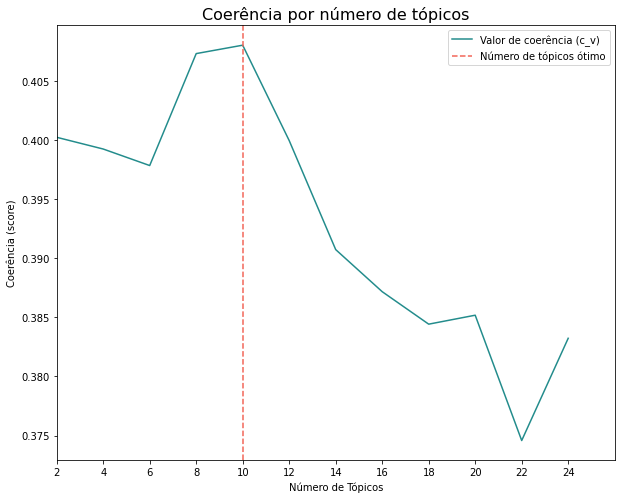

In [603]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'unigrams')

#### **Bigrams LDA**

In [604]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Tokenize the text data
tokens = [simple_preprocess(doc, min_len=4) for doc in documents]

# create bigrams
bigram = Phrases(tokens, min_count=1, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens]

# create a dictionary from the bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above==0.80)

# create a corpus from the bigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

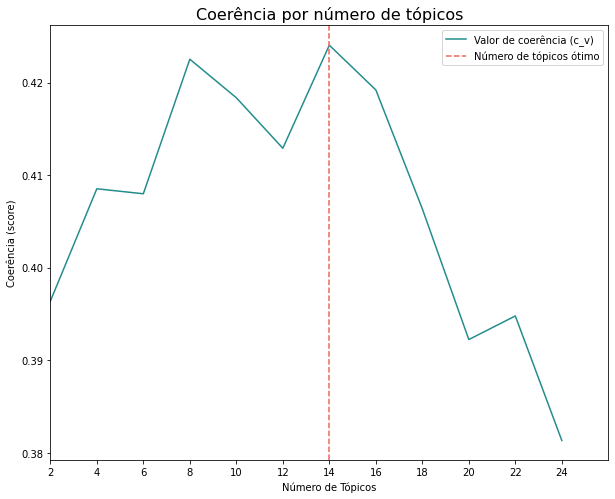

In [605]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'bigrams')

#### **Trigrams LDA**

In [606]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# tokenize the text data
tokens = [simple_preprocess(doc,min_len=4) for doc in documents]

# Create trigrams
trigram = Phrases(tokens, min_count=1, threshold=1)
trigram_phraser = Phraser(trigram)
texts = [trigram_phraser[bigram_phraser[token]] for token in tokens]

# create a dictionary from the trigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
#dictionary.filter_extremes(no_above=0.80)

# create a corpus from the trigrams
corpus = [dictionary.doc2bow(text) for text in texts]

# create a dict to store the coherence scores
coherence_scores = {}

# create LDA models for different number of topics
for num_topics in range(2, NUMBER_OF_TOPICS, 2):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary, 
                             num_topics=num_topics,
                             random_state=100,
                             passes=2,
                             iterations=100)
    
    coherence_model = CoherenceModel(model=lda_model, 
                                     texts=texts,
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_scores[num_topics] = coherence_model.get_coherence()

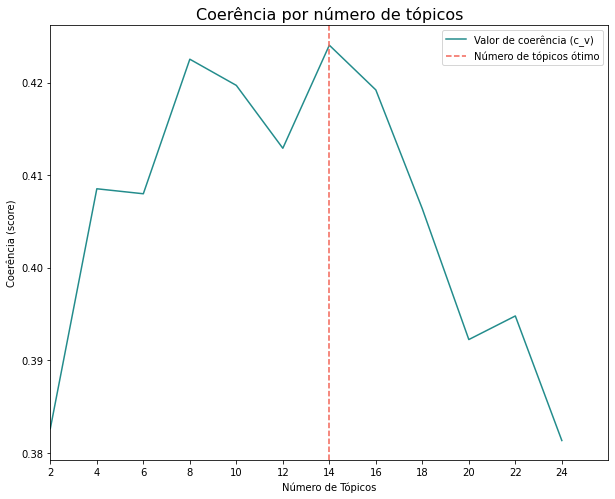

In [607]:
plot_coherence(coherence_scores, NUMBER_OF_TOPICS, 'trigrams')

#### **Hyperparameter tuning**

In [608]:
# set the minimum and maximum number of topics based on coherence score plots
MIN_TOPICS = max(min(optimum_topics) - 2, 2)
MAX_TOPICS = max(optimum_topics) + 2
def optimizer(trial):
  alpha = trial.suggest_float('lda_alpha', 0.01, 1.0)
  eta = trial.suggest_float('lda__eta', 0.01, 1.0)
  nr_topics = trial.suggest_int('lda__nr_topics', MIN_TOPICS, MAX_TOPICS)
  min_count = trial.suggest_int('bigram__min_count', 2, 20)
  filter = trial.suggest_float('dictionary__filter_extremes', 0.70, 0.95)

  # tokenize the text data
  tokens = [simple_preprocess(doc, min_len=4) for doc in documents]

  # add bigrams to docs (only ones that appear x times or more).
  bigram = Phrases(tokens, min_count=min_count, threshold=1)
  bigram_phraser = Phraser(bigram)
  texts = [bigram_phraser[token] for token in tokens] 
  
  # create a corpus from a list of texts
  dictionary = Dictionary(texts)

  # Filter out words that occur more than X% of the documents.
  dictionary.filter_extremes(no_above=filter)

  # convert documents to bag of words
  corpus = [dictionary.doc2bow(text) for text in texts]

  # create a new LDA model
  lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=nr_topics,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)
  
  # compute coherence score
  score = CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence()

  new_file = False
  # write header if document does not exists
  if not os.path.exists(os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')):
       new_file = True

   # save scores
  if not os.path.exists(LDA_RESULTS_DIR):
     os.makedirs(LDA_RESULTS_DIR)

  with open(path, 'a', newline='') as f:
     fieldnames = ['score', 'topic', 'alpha', 'eta', 'min_count', 'filter']
     writer = csv.DictWriter(f, fieldnames=fieldnames)
     data = [{'score': score,
              'topic': nr_topics, 
              'alpha': alpha,
              'eta': eta,
              'min_count': min_count,
              'filter':filter}]
     if new_file:
       writer.writeheader()
    
     # write rows
     writer.writerows(data)
  return  score

In [609]:
%%time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# delete csv if it exists
path = os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')
if os.path.exists(path):
  os.remove(path)

NUMBER_OF_MODELS = 20

# create a new study
study = optuna.create_study(study_name=f'LDA_{COLNAME}', direction='maximize')

# run the optmize function 
study.optimize(optimizer, n_trials=NUMBER_OF_MODELS, show_progress_bar=True)

# best
print('Best value %s', study.best_value)
print('Best params: %s', study.best_params)

/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-01-24 00:21:01,055] Trial 0 finished with value: 0.4125242372246474 and parameters: {'lda_alpha': 0.8596593795804924, 'lda__eta': 0.14133785922801936, 'lda__nr_topics': 12, 'bigram__min_count': 2, 'dictionary__filter_extremes': 0.7085053151376223}. Best is trial 0 with value: 0.4125242372246474.
[I 2023-01-24 00:21:28,365] Trial 1 finished with value: 0.38737940893613354 and parameters: {'lda_alpha': 0.9407001083826518, 'lda__eta': 0.36503056125101757, 'lda__nr_topics': 10, 'bigram__min_count': 15, 'dictionary__filter_extremes': 0.7733517261937155}. Best is trial 0 with value: 0.4125242372246474.
[I 2023-01-24 00:21:55,368] Trial 2 finished with value: 0.4103935586554931 and parameters: {'lda_alpha': 0.9908798960927049, 'lda__eta': 0.15152096772666743, 'lda__nr_topics': 10, 'bigram__min_count': 11, 'dictionary__filter_extremes': 0.8999110574382886}. Best is trial 0 with value: 0.4125242372246474.
[I 2023-01-24 00:22:39,350] Trial 3 finished with value: 0.4019535017868066 and pa

#### **Visualization of Topics**

In [610]:
def save_lda_vis(prefix, lda, nr_topics, corpus, dictionary):
  path = os.path.join(LDA_RESULTS_DIR, f'ldavis_{str(nr_topics)}')

  vis = gs.prepare(lda, corpus, dictionary)
 
  with open(path, 'wb') as f:
        pickle.dump(vis, f)

  with open(path, 'rb') as f:
    vis = pickle.load(f)
  
  pyLDAvis.save_html(vis, os.path.join(LDA_RESULTS_DIR, f'{prefix}_ldavis_{str(nr_topics)}.html'))

In [611]:
def get_topics(lda, nr_topics):
  x=lda.show_topics(num_topics=nr_topics, num_words=10, formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
  topics = []
  words = []
  for t, w in topics_words:
    topics.append(t)
    words.append(w)
  return pd.DataFrame({'Tópicos': topics, 'Words': words})

In [612]:
def get_words_by_topic_id(lda, topic_id, topn=20):
  return [dictionary[word_id] for word_id, prob in lda.get_topic_terms(topic_id, topn=topn)]

In [613]:
def get_words_n_score_by_topic_id(lda, topics, topn=10):
  ls = []
  for id in topics:
    ls.append([(dictionary[word_id], prob) for word_id, prob in lda.get_topic_terms(id, topn=topn)])
  return ls

#### **Topics of the optimized model**

In [614]:
filename = os.path.join(LDA_RESULTS_DIR, f'coherence_scores.csv')
df_opt = pd.read_csv(filename)

# init variables
max_value = df_opt['score'].max()
row = df_opt.loc[df_opt['score'] == max_value]
alpha = row['alpha'].astype(float).values[0]
eta = row['eta'].astype(float).values[0]
NUMBER_OF_TOPICS = max(row['topic'].astype(int).values[0], 4)
min_count = row['min_count'].astype(int).values[0]

# tokenize the text data
tokens = [simple_preprocess(doc, min_len=4) for doc in documents]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=min_count, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[token] for token in tokens] 
  
# create a corpus from a list of texts
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.60)

# convert documents to bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUMBER_OF_TOPICS,
                           random_state=100,
                           passes=2,
                           iterations=100,
                           alpha=alpha,
                           eta=eta)

# save topics terms
topics_terms = get_topics(lda_model, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, 'topics_terms_optimized_model.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)

,Tópicos,Words
0,0,"[pedir, entregar, produto, receber, empresa, e..."
1,1,"[pedir, entregar, compra, querer, entrar_conta..."
2,2,"[compra, pedir, produto, entregar, empresa, si..."
3,3,"[produto, compra, pedir, entregar, agora, faze..."
4,4,"[compra, pedir, produto, entregar, problema, c..."
5,5,"[compra, produto, pedir, entregar, site, fazer..."
6,6,"[pedir, site, produto, cartão, compra, entrega..."
7,7,"[produto, pedir, compra, site, entregar, receb..."
8,8,"[pedir, entregar, comprar, produto, loja, celu..."
9,9,"[produto, entregar, pedir, entrar_contato, com..."


In [615]:
print(CoherenceModel(lda_model, texts=texts, corpus=corpus, dictionary=dictionary).get_coherence())

0.4144162358846751


In [616]:
save_lda_vis('optimized', lda_model, NUMBER_OF_TOPICS, corpus, dictionary)

vis = gs.prepare(lda_model, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


The intertopic distance map is a graphical representation of topics in a two-dimensional way. Different sized circles are used to show different topics and the area of these circles is proportional to the number of words related to these topics in a dictionary. Multidimensional scaling algorithm is used to plot the circles in relation to the words they contain, so topics that are close to each other have a large amount of shared terms.

The bar chart displayed by default contains the 30 most salient terms from the corpus. Salient is a metric used to determine which words are the most useful for identifying topics in the entire set of texts. The bars on the chart signify the total frequency of each term across the corpus, with darker bars indicating a greater frequency of the term specifically belonging to the selected topic. If the darker bar entirely covers the light-colored bar, it indicates that the term almost exclusively belongs to the selected topic.

Lambda is a parameter used to determine the relevance of words in a given topic. When you adjust lambda to a lower number, such as 0, you are more likely to find words that are exclusive to the selected topic, but these words may be rare. If you adjust lambda to a higher number closer to 1, the words you find will be more frequent, but they may not necessarily belong exclusively to the selected topic.

Salience is a measure used to identify which words are the most important for determining the topics in all the documents. The higher the saliency value, the more useful the word is for identifying a specific topic. A saliency value cannot be negative and there is no maximum value it can have. If a word has a saliency value of 0, this means it is equally related to all topics. Saliency looks at words in terms of the entire corpus (all the texts combined) rather than focusing on one particular topic.

Relevance is a measure used to determine the importance of words within a topic. It helps identify which words are the most important for that particular topic and how much they are related to that topic as opposed to other topics. Relevance also considers a parameter called lambda that takes into account how likely it is for a certain term to be part of a topic compared to its lift.

Reference: https://aclanthology.org/W14-3110.pdf

#### **Plot topics terms**

In [653]:
def plot_topics_terms(lda, filename):

  topics = range(0, min(lda.num_topics, 8), 2)

  data = get_words_n_score_by_topic_id(lda, topics, topn=10)

  if lda.num_topics >= 4:
    figheight = 5
    figwidth = 22
    fontsize = 20
    labelsize = 16
  else:
    figheight = 3
    figwidth = 12
    fontsize = 12
    labelsize = 10


  fig, axs = plt.subplots(1, len(topics), figsize=(figwidth, figheight), tight_layout=True)

  for i, ax in enumerate(axs):
      terms = [d[0] for d in data[i]]
      scores = [d[1] for d in data[i]]
      sns.barplot(x=scores, y=terms, orient="h", ax=ax)
      ax.set_title("Tópico {}".format(topics[i]), fontsize = fontsize)
      ax.tick_params(axis='x', labelsize=labelsize)
      ax.tick_params(axis='y', labelsize=labelsize)

  plt.savefig(os.path.join(LDA_RESULTS_DIR, filename))
  plt.show()

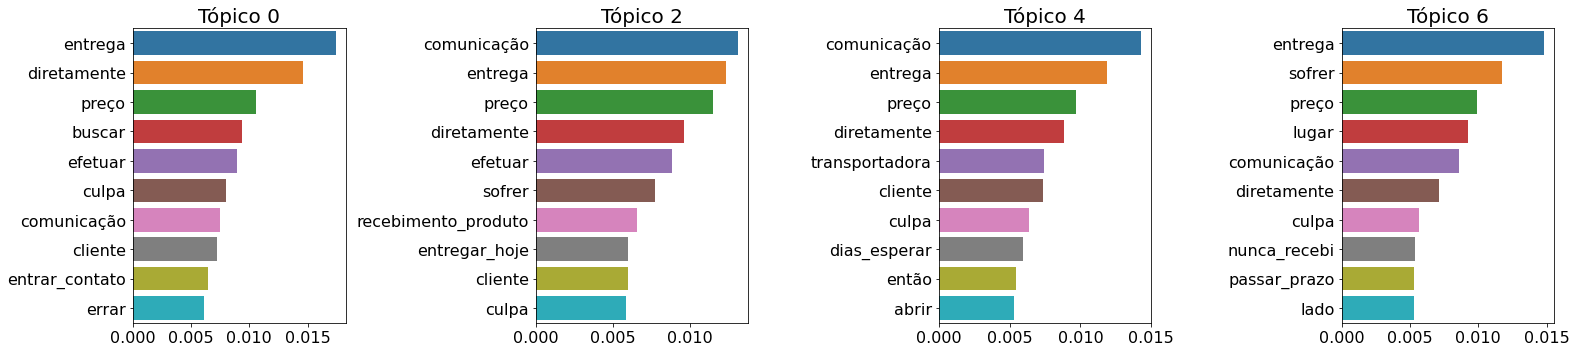

In [654]:
plot_topics_terms(lda_model, 'optimized_model_topics_terms_plot.png')

#### **Wordclouds of optimized model**

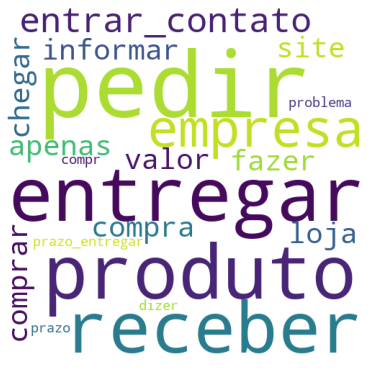

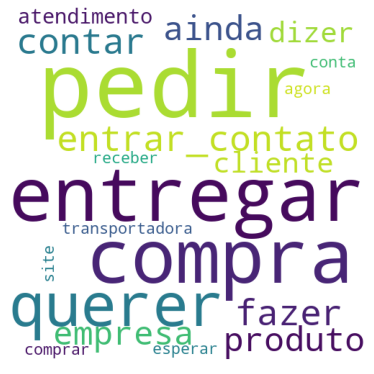

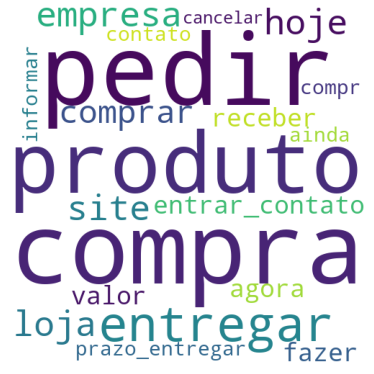

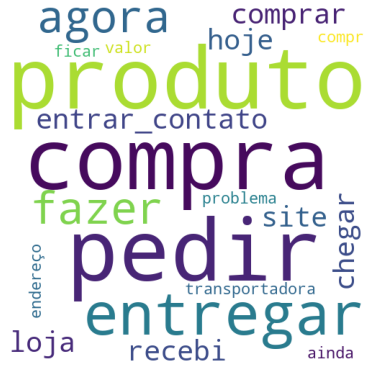

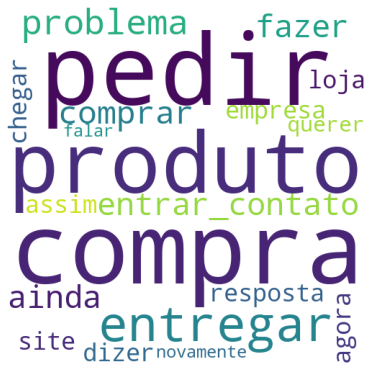

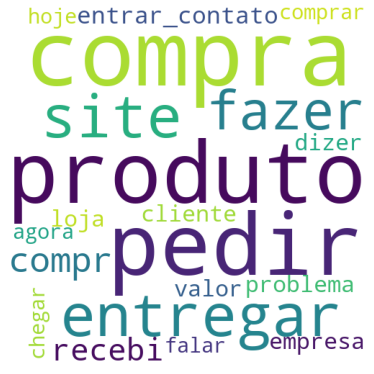

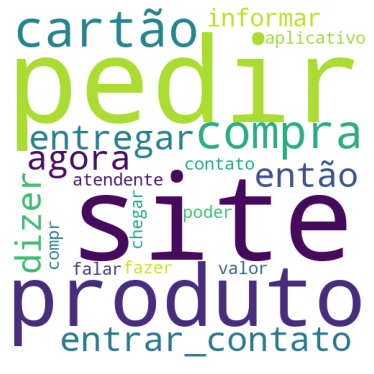

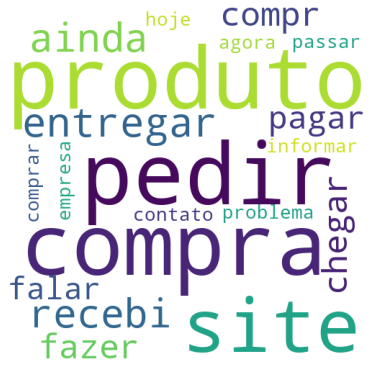

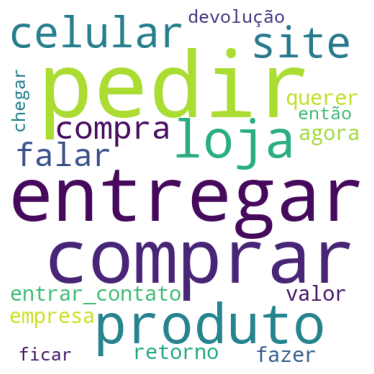

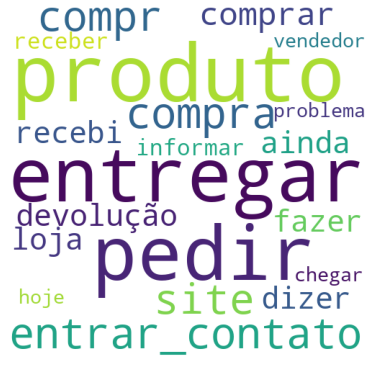

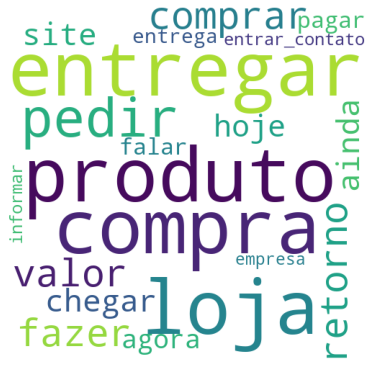

In [619]:
for t in range(lda_model.num_topics):
  wordcloud = WordCloud(width = 500, height = 500,
                      collocations = False,
                      background_color ='white', 
                      colormap='viridis',
                      random_state=20).generate_from_text(' '.join(get_words_by_topic_id(lda_model, t)))
  plt.figure(figsize=(5,5), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0) 
  dir = os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud')
  if not os.path.exists(dir):
    os.makedirs(dir)
  plt.savefig(os.path.join(LDA_RESULTS_DIR, 'optimized_model_wordcloud', f'optimization_wordcloud_topic_{str(t)}.png'))
  print()

#### **Cluster 0 topics visualization**

In [620]:
tokens = [simple_preprocess(doc, min_len=4) for doc in cluster_0.texts]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

# create a dictionary of bigrams
dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.60)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_0 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUMBER_OF_TOPICS,
                           random_state=100,
                           passes=10,
                           iterations=100)

save_lda_vis('cluster_0', lda_model_cluster_0, NUMBER_OF_TOPICS, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_0, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_0.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)

vis = gs.prepare(lda_model_cluster_0, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


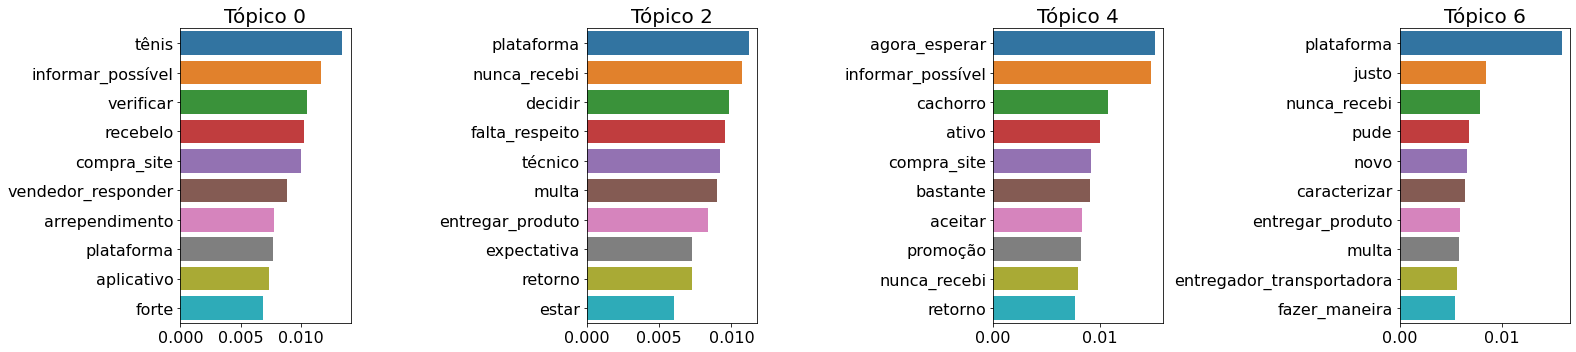

In [655]:
plot_topics_terms(lda_model_cluster_0, 'cluster_0_topics_terms_plot.png')

#### **Cluster 1 topics visualization**

In [622]:
tokens = [simple_preprocess(doc, min_len=4) for doc in cluster_1.texts]

# add bigrams to docs (only ones that appear x times or more).
bigram = Phrases(tokens, min_count=2, threshold=1)
bigram_phraser = Phraser(bigram)
texts = [bigram_phraser[doc] for doc in tokens] 

dictionary = Dictionary(texts)

# Filter out words that occur more than X% of the documents.
dictionary.filter_extremes(no_above=0.60)

corpus = [dictionary.doc2bow(text) for text in texts]

# create a new LDA model
lda_model_cluster_1 = LdaMulticore(corpus=corpus,
                           id2word=dictionary,
                           num_topics=NUMBER_OF_TOPICS,
                           random_state=100,
                           passes=10,
                           iterations=100)

save_lda_vis('cluster_1', lda_model_cluster_1, NUMBER_OF_TOPICS, corpus, dictionary)

# save topic terms
topics_terms = get_topics(lda_model_cluster_1, NUMBER_OF_TOPICS)
topics_terms.to_csv(os.path.join(LDA_RESULTS_DIR, f'topics_terms_cluster_1.csv'), index=False)
topics_terms.head(NUMBER_OF_TOPICS)

vis = gs.prepare(lda_model_cluster_1, corpus, dictionary)
gs.pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


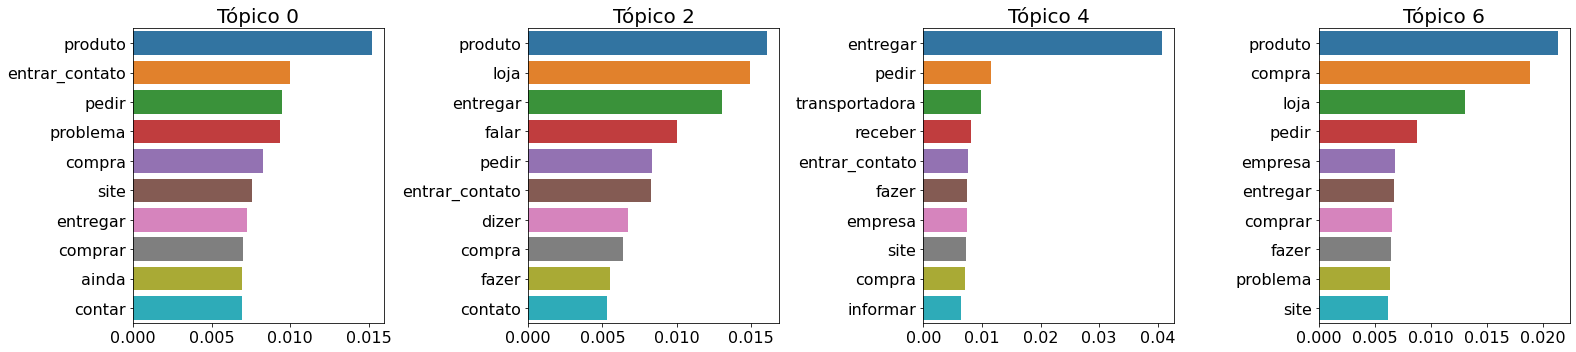

In [656]:
plot_topics_terms(lda_model_cluster_1,  'cluster_1_topics_terms_plot.png')

In [713]:
!rm -rf /root/.ssh/